# _Investigation into sampled sound files part 1: pitch_

By _Jacques Leplat_

2019 - Present



## Data source and domain description

The goal of this project is to extract the pitches that are present in sound samples, possibly extracting a rudimentary list of the notes found.

Wav Sound files are a common file format that can encode recorded sounds and music into a binary file that can be analyzed or played to reproduce the sound that was originally encoded. 

A good initial wav file dataset is http://www.iainmccurdy.org/soundlibrary.html a vast library of samples maintained by: 
 - Ian Mc Curdy,
   Maynooth University
   http://iainmccurdy.org/index.html

Additional sample files are easy to come by, and can be generated to fit specific parameters. Csound (https://csound.com) is a cross platform audio programming language that can be used standalone or in Python. Using Csound it is possible to generate audio with a specific waveform, amplitude, pitch and duration. Csound has facilities to load and save sound files in many formats.

***



## Analysis Strategy and Plans

The initial approach has two tasks:

- Search for publications on the subject of audio analysis, with a focus on musical audio. 
- Write code snippets to evaluate a set of tools that are necessary to complete the project.

Several papers and websites have been found so far, some with very relevant content:

- [CSound Floss manual](http://floss.booktype.pro/csound/preface/)
- [Wave file specifications](http://www-mmsp.ece.mcgill.ca/Documents/AudioFormats/WAVE/WAVE.html)
- [The Timbre Toolbox: Extracting audio descriptors from musical signals](https://www.researchgate.net/publication/51802556_The_Timbre_Toolbox_Extracting_audio_descriptors_from_musical_signals)
- [Librosa a Python library for audio and music analysis](http://librosa.github.io/librosa/index.html#)
- The Audio Programming Book edited by Richard Boulanger and Victor Lazzarini. 2011, MIT Press
- Designing Sound by Andy Farnell. 2010, MIT Press
- The Csound Book, edited by Richard Boulanger, 2000, MIT Press
- Csound Power! The Comprehensive Guide, by Jim Aikin, 2013, Cengage Learning

Sound is commonly described as pitch amplitude and timbre.
-  Pitch is the focus of this coursework, a [Fourier transformation]( https://en.wikipedia.org/wiki/Fourier_analysis) looks like a promising way of extracting pitch.

The hope is that a way is found to extract the main pitch's that are present in the samples: pitch start (offset from the start of the sample in milliseconds), pitch (frequency in Hertz) and duration (in milliseconds).

wav files can be encoded using a variety of encodings. For this project, the variety has been narrowed down to 24 or 16 bit sample size, 44100 or 9600 samples per second, stereo (2 channel).

***
***

## Initial investigations on the data sources: 

Initial code has been written to load several sample files, some downloaded, others generated using [Csound](https://csound.com). The code uses the wav audio facilities that are present in Python. 
- Sound of a water drip ([Iain Mc Curdy](http://www.iainmccurdy.org/soundlibrary.html#IDsoundlibrary-Drips-Drips-Drips01-))
- Three chords (csound source: classicTest.csd)
- Twelve notes (csound source: allNotes.csd)
- Six individual piano samples of single notes ([Iain Mc Curdy](http://www.iainmccurdy.org/soundlibrary.html#IDsoundlibrary-PianoMiscellaneous-Notes-))

Wav file support in Python is basic, trying to load a 16/24 bit, little endian sample file, required quite a bit of effort.

When plotted using a spectrogram, the musical files display a pattern, whereas the water drip less so. The next steps are to attempt to extract the relevant frequencies of the notes played in the sample file. Only the left channel is displayed in the plots, this reduces the amount of plots displayed by half. The samples chosen should be in the central region of the audio space.

***
***

## Python code for initial investigations

In [7]:
import numpy as np
import wave
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [11, 3]

import functools as fnt

# wav file specs: http://www-mmsp.ece.mcgill.ca/Documents/AudioFormats/WAVE/WAVE.html
# http://iainmccurdy.org/soundlibrary.html#IDsoundlibrary-
# 24/16 bit sound file, 2 channels, WAV File 96Khz/44100 sample rate
noteTestFilename = "noteTest.wav"
waterDripFilename = 'Drips01_01.wav'
threeChordsFilename = 'classicTest.wav'
octaveTestFilename = "octaveTest.wav"
pianoFilenames = ["PianoNote01.wav", "PianoNote02.wav", "PianoNote03.wav", "PianoNote04.wav", "PianoNote05.wav", "PianoNote06.wav"]

MIN_24_BIT = - 8388608
MAX_24_BIT = 8388607
MAX_16_BIT = 32767
MIN_16_BIT = - 32768

#
# Class that wraps a wav file: contains sample information and contents
# as 2 numpy arrays of floats (-1.0 .. 1.0)
#
class WavFile():
    filename = "No wav file loaded"
    nFrames = 0
    nChannels = 0
    sampleWidth = 0
    sampleRate = 0
    sampleDuration = 0.0
    leftChannel = np.zeros(1, dtype='float32')
    rightChannel = np.zeros(1, dtype='float32')

    #
    # Load file's byte stream (24 bit little endian ints) and convert it
    #
    # returns np.array tuple: leftChannel, rightChannel of normalised sample values -1.0 - 1.0
    #
    def get24BitSamples(self, w):
        w.rewind()
        framesToRead = w.getnframes()
        left = np.zeros(framesToRead, dtype='float32')
        right = np.zeros(framesToRead, dtype='float32')

        for i in range(0, framesToRead):
            frameBytes = w.readframes(1)
            value1 = int.from_bytes(frameBytes[0:3], byteorder='little', signed=True)
            value2 = int.from_bytes(frameBytes[3:6], byteorder='little', signed=True)
            # Normalise sample values to a range -1.0 - 1.0, use maximum absolute value for normalisation
            left[i] = value1 / abs(MIN_24_BIT)
            right[i] = value2 / abs(MIN_24_BIT)
        return left, right
    
    #
    # Load file's byte stream (16 bit little endian ints) and convert it
    #
    # returns np.array tuple: leftChannel, rightChannel of normalised sample values -1.0 - 1.0
    #    
    def get16BitSamples(self, w):
        w.rewind()
        framesToRead = w.getnframes()
        left = np.zeros(framesToRead, dtype='float32')
        right = np.zeros(framesToRead, dtype='float32')

        for i in range(0, framesToRead):
            frameBytes = w.readframes(1)
            value1 = int.from_bytes(frameBytes[0:2], byteorder='little', signed=True)
            value2 = int.from_bytes(frameBytes[2:4], byteorder='little', signed=True)
            # Normalise sample values to a range -1.0 - 1.0, use maximum absolute value for normalisation
            left[i] = value1 / abs(MIN_16_BIT)
            right[i] = value2 / abs(MIN_16_BIT)
        return left, right

    #
    # constructor. Opens sample wav file and loads the contents.
    #
    def __init__(self, filename):
        with wave.open(filename, 'r') as wav_file:
            # Read & Display sample file's details:
            self.filename = filename
            self.nFrames = wav_file.getnframes()
            self.nChannels = wav_file.getnchannels()
            self.sampleWidth = wav_file.getsampwidth()
            self.sampleRate = wav_file.getframerate()
            self.sampleDuration = self.nFrames / self.sampleRate
            if self.sampleWidth == 2:
                self.leftChannel, self.rightChannel = self.get16BitSamples(wav_file)
            else:
                self.leftChannel, self.rightChannel = self.get24BitSamples(wav_file)
                
    def printSummary(self):
            print("Filename: ", self.filename, " Duration: ", str(self.sampleDuration), " Channels: ", 
                  self.nChannels, " Bytes per sample: ", self.sampleWidth, "Sample rate: ", 
                  self.sampleRate, "Number of samples: ", self.nFrames)
#
# Plot sample: left channel and right channel
#
def plotFile(wavFile):
    # plot the sample (left & right channels)
    timeValues = np.linspace(0, wavFile.nFrames, wavFile.nFrames)
    timeValues2 = np.linspace(0, wavFile.sampleDuration, wavFile.nFrames)
    timeValues2 = np.around(timeValues2, 4)
    figure = plt.figure()

    axe = figure.add_subplot(1, 2, 1)
    axe.set_title('Left Channel ')
    axe.set_xlabel("Frame number")
    axe.set_ylabel("Sample value")
    axe.tick_params(axis='both', which='major', labelsize=10)
    axe.plot(timeValues, wavFile.leftChannel, linewidth=1)
    plt.axis([0, wavFile.nFrames, -1.0, 1.0])

    axe = figure.add_subplot(1, 2, 2)
    axe.set_title('Right Channel ')
    axe.set_xlabel("Frame number")
    axe.set_ylabel("Sample value")
    axe.tick_params(axis='both', which='major', labelsize=10)
    axe.plot(timeValues, wavFile.rightChannel, linewidth=1)
    plt.axis([0, wavFile.nFrames, -1.0, 1.0])
    plt.show()

#
# Plot spectogram: left channel and right channel
#
def plotSpectogram(wavFile):
    figure = plt.figure()

    logFix = wavFile.leftChannel + 1
    axe = figure.add_subplot(1, 2, 1)
    axe.set_title('Left Channel ')
    axe.set_xlabel("Time")
    axe.set_ylabel("Frequency")
    axe.specgram(logFix, Fs=wavFile.sampleRate)

    logFix = wavFile.rightChannel + 1
    axe = figure.add_subplot(1, 2, 2)
    axe.set_title('Right Channel ')
    axe.set_xlabel("Time")
    axe.set_ylabel("Frequency")
    axe.specgram(logFix, Fs=wavFile.sampleRate)

    plt.show()
    
#
# Plot sample and spectogram (left channel)
#
def plotSampleSpectogram(wavFile):
    timeValues = np.linspace(0, wavFile.nFrames, wavFile.nFrames)
    figure = plt.figure()

    axe = figure.add_subplot(1, 2, 1)
    axe.set_title('Sample & Time')
    axe.set_xlabel("Frame number")
    axe.set_ylabel("Sample value")
    axe.tick_params(axis='both', which='major', labelsize=10)
    axe.plot(timeValues, wavFile.leftChannel, linewidth=1)
    plt.axis([0, wavFile.nFrames, -1.0, 1.0])

    logFix = wavFile.leftChannel + 1
    #axe = figure.add_subplot(1, 2, 2, projection='polar')
    axe = figure.add_subplot(1, 2, 2,)
    axe.set_title('Frequency & Time Spectogram')
    axe.set_xlabel("Time")
    axe.set_ylabel("Frequency")
    axe.specgram(logFix, Fs=wavFile.sampleRate)

    plt.show()

### Plot One Note
Csound generated note 440 Hz: noteTest.csd

Filename:  noteTest.wav  Duration:  0.23900226757369614  Channels:  2  Bytes per sample:  3 Sample rate:  44100 Number of samples:  10540


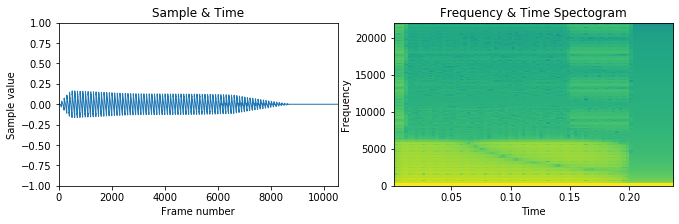

In [8]:
wavFile = WavFile(noteTestFilename)
wavFile.printSummary()
plotSampleSpectogram(wavFile)

### Plot An Octave 
Frequencies in Hertz: 277.190, 293.656, 311.127, 329.637, 349.218, 369.994, 392.006, 415.293, 440.000, 466.177, 493.869
Generated using allNotes.csd

Filename:  octaveTest.wav  Duration:  3.0011791383219957  Channels:  2  Bytes per sample:  3 Sample rate:  44100 Number of samples:  132352


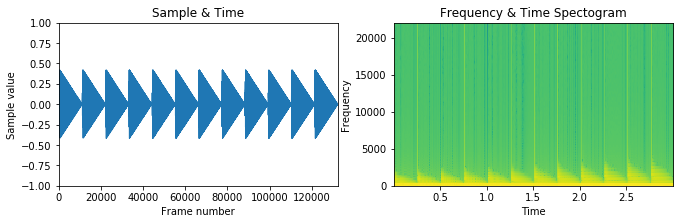

In [9]:
# 12 notes (FM synthesis)
wavFile = WavFile(octaveTestFilename)
wavFile.printSummary()
plotSampleSpectogram(wavFile)

### Plot a Water Drip Sample File
Downloaded from: http://iainmccurdy.org/soundlibrary.html
        

Filename:  Drips01_01.wav  Duration:  0.8126666666666666  Channels:  2  Bytes per sample:  3 Sample rate:  96000 Number of samples:  78016


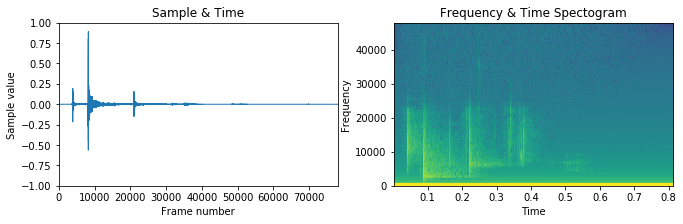

In [10]:
# water drip
wavFile = WavFile(waterDripFilename)
wavFile.printSummary()
plotSampleSpectogram(wavFile)

### Plot 3 Chords
Generated using Csound: classicTest.csd

Filename:  classicTest.wav  Duration:  0.719954648526077  Channels:  2  Bytes per sample:  3 Sample rate:  44100 Number of samples:  31750


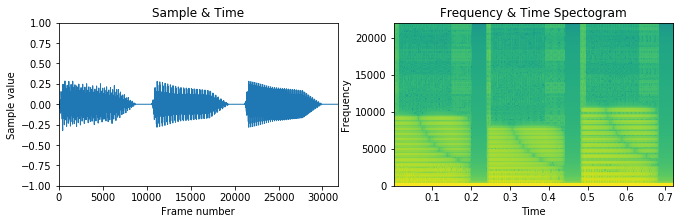

In [11]:
# 3 musical chords (Sawtooth waveform)
wavFile = WavFile(threeChordsFilename)
wavFile.printSummary()
plotSampleSpectogram(wavFile)

PLot 6 Piano Samples
Downloaded from:  http://iainmccurdy.org/soundlibrary.html (soundlibrary/PianoMiscellaneous/Notes)

Filename:  PianoNote01.wav  Duration:  31.172789115646257  Channels:  2  Bytes per sample:  2 Sample rate:  44100 Number of samples:  1374720


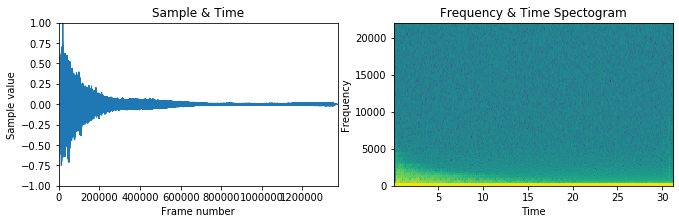

Filename:  PianoNote02.wav  Duration:  32.04353741496599  Channels:  2  Bytes per sample:  2 Sample rate:  44100 Number of samples:  1413120


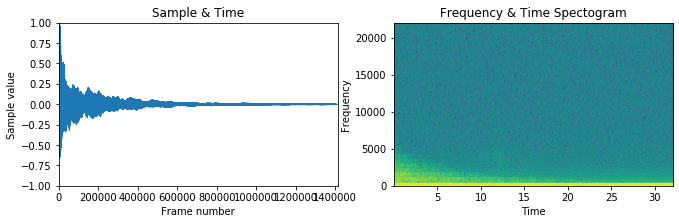

Filename:  PianoNote03.wav  Duration:  19.89950113378685  Channels:  2  Bytes per sample:  2 Sample rate:  44100 Number of samples:  877568


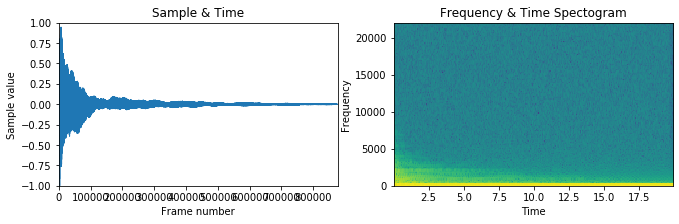

Filename:  PianoNote04.wav  Duration:  20.54965986394558  Channels:  2  Bytes per sample:  2 Sample rate:  44100 Number of samples:  906240


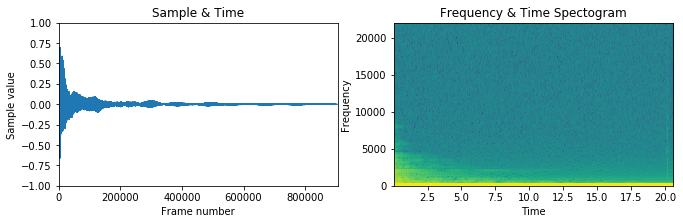

Filename:  PianoNote05.wav  Duration:  15.371609977324264  Channels:  2  Bytes per sample:  2 Sample rate:  44100 Number of samples:  677888


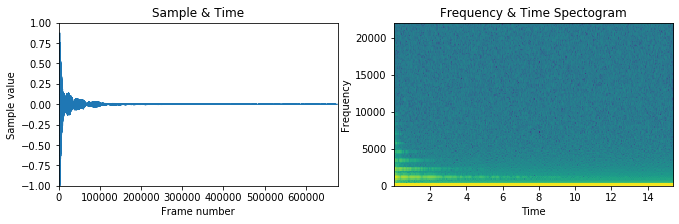

Filename:  PianoNote06.wav  Duration:  6.524807256235827  Channels:  2  Bytes per sample:  2 Sample rate:  44100 Number of samples:  287744


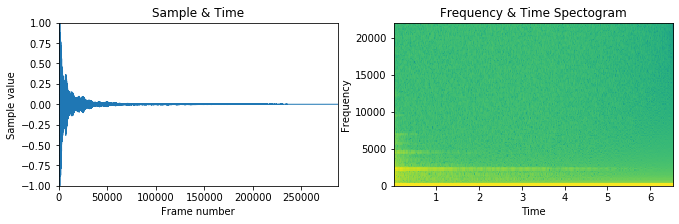

In [12]:
# piano 
for pianoFilename in pianoFilenames:
    wavFile = WavFile(pianoFilename)
    wavFile.printSummary()
    plotSampleSpectogram(wavFile)